In [1]:
import numpy as np
import torch
import torch.nn as nn
from scipy import interpolate
import scipy
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from tqdm import tqdm

from vanilla_fem import *
from pod_fem import *
from deim_fem import *
from neim_fem2 import *
from other_functions import *

torch.manual_seed(0)
np.random.seed(0)

import sys
from pathlib import Path

Path("./Paper Figures/").mkdir(parents=True, exist_ok=True)
Path("./Paper Data/").mkdir(parents=True, exist_ok=True)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Parameters
The parameters which we will let vary are $a$ so that
$$
    (a,) \in \mathbb{P} = [-0.5, 0.5].
$$

In [2]:
parameters = []
for a in np.linspace(-0.5, 0.5, 10):
    parameters.append((a,))

b = 0.5
c = 1
A0 = 500
M = 1
L = 0.1

# number of time steps and final time
Nt = 80
t_final = 4
tVals = np.linspace(0, t_final, Nt)
dt = tVals[1] - tVals[0] # delta t

In [3]:
# define the mesh in space
mesh, interior_point_coords = get_triangulation(refinements=5)

# Get the finite element space, stiffness matrix, lumped mass matrix as a vector, and mass matrix
Vh, stiffness_matrix, gamma, mass_matrix = calculate_basis_integrals(mesh)

## Solve High Fidelity PDE
Note that we only keep track of nodes in the interior of $\Omega$ because we use homogeneous Dirichlet boundary conditions.

In [4]:
hf_solutions = []
for (a,) in parameters:
    # Get vectors for the components of matrices (flattened over space) 
    # over time with time 0 initialized.
    Q1, Q2, p1, p2, r, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)

    # solve the PDE (updates the entries of Q1, Q2, etc. within the function)
    solve_Q_flow(Q1, Q2, p1, p2, r, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)
    
    hf_solutions.append((Q1, Q2, p1, p2, r))

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.46it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.51it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.23it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.83it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.16it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.19it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.28it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.35it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.54it/s]


Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.19it/s]


## Compute POD Matrices

In [5]:
Q1 = []
Q2 = []
p1 = []
p2 = []
r  = []
for sol in hf_solutions:
    Q1.append(sol[0])
    Q2.append(sol[1])
    p1.append(sol[2])
    p2.append(sol[3])
    r.append(sol[4])

Q1 = np.concatenate(Q1, axis=0)
Q2 = np.concatenate(Q2, axis=0)
p1 = np.concatenate(p1, axis=0)
p2 = np.concatenate(p2, axis=0)
r  = np.concatenate(r, axis=0)

max_rank = 5
U_Q1, U_Q2, U_r = get_POD_matrices(Q1, Q2, r, max_rank)

## Compare POD Solution to High Fidelity Solution (New Parameter)

In [6]:
a = -0.2

Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

Q1_pod, Q2_pod, p1_pod, p2_pod, r_pod = initialize_Q_flow_POD(Q1_, Q2_, p1_, p2_, r_, U_Q1, U_Q2, U_r)
solve_Q_flow_POD(Q1_pod, Q2_pod, p1_pod, p2_pod, r_pod, gamma, stiffness_matrix, U_Q1, U_Q2, U_r, Nt, a, b, c, A0, M, L, dt)

print("Relative Error:", np.linalg.norm(Q1_ - (U_Q1 @ Q1_pod.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.27it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 511.93it/s]


Relative Error: 0.019050948314289433


## Compute DEIM Operators

In [7]:
deim_modes = 10

nonlinearityQ = M * gamma.reshape(-1, 1) * np.concatenate([p1 * r, p2 * r], axis=0).T
UN_Q, nQ_indices = get_DEIM_operators(nonlinearityQ, deim_modes)
U_deimQ1 = U_Q1.T @ UN_Q
U_deimQ2 = U_Q2.T @ UN_Q

nonlinearityR = (2 * p1[:-1] * (Q1[1:] - Q1[:-1]) + 2 * p2[:-1] * (Q2[1:] - Q2[:-1])).T
UN_R, nR_indices = get_DEIM_operators(nonlinearityR, deim_modes)
U_deimR = U_r.T @ UN_R

## Compare DEIM Solution to High Fidelity Solution (New Parameter)

In [8]:
a = -0.15

Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim = initialize_Q_flow_DEIM(Q1_, Q2_, p1_, p2_, r_, 
                                                                                          U_Q1, U_Q2, U_r, 
                                                                                          nQ_indices, nR_indices)
solve_Q_flow_DEIM(Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim, 
                    gamma, stiffness_matrix, 
                    U_Q1, U_Q2, U_r, U_deimQ1, U_deimQ2, U_deimR,
                    nQ_indices, nR_indices,
                    Nt, a, b, c, A0, M, L, dt)

print("Relative Error:", np.linalg.norm(Q1_ - (U_Q1 @ Q1_deim.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.67it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 888.30it/s]


Relative Error: 0.018613606294059053


## Compute NEIM Operators

In [9]:
neim_modes = 4

### $Q$ Equation NEIM

TODO: Generalize so that we only use data within 10 indices in time for each example (to cut down on computation time and reduce required capacity for neural nets)

In [10]:
time_frequency = 1
mu = []

for (a,) in parameters:
    for t in range(0, Nt, time_frequency):
        mu.append([t, a])
mu = np.array(mu)

num_time_params = len(range(0, Nt, time_frequency))

In [11]:
ro_sols = np.zeros((mu.shape[0], 3*max_rank))
f_NEIM  = np.zeros((mu.shape[0], mu.shape[0], 2*max_rank))

# iterate over solution parameter
for i, param1 in enumerate(mu):
    Q1_, Q2_, _, _, r_ = hf_solutions[i // num_time_params]
    Q1_, Q2_, r_ = Q1_[i % num_time_params], Q2_[i % num_time_params], r_[i % num_time_params]
    
    ro_sols[i] = np.concatenate([Q1_ @ U_Q1, Q2_ @ U_Q2, r_ @ U_r])
    
    # iterate over nonlinearity parameter
    for j, param2 in enumerate(mu):
        # evaluate Nonlinearity(solution(param1); param2)
        (t, a) = param2
        
        Q = np.concatenate((
                np.concatenate((Q1_[:, None, None], Q2_[:, None, None]), axis=2),
                np.concatenate((Q2_[:, None, None], -Q1_[:, None, None]), axis=2),
        ), axis=1)
        PQ = P(Q, a, b, c, A0)
        p1_ = PQ[:, 0, 0]
        p2_ = PQ[:, 0, 1]
        
        nonlinearityQ = M * np.concatenate([(gamma[None] * p1_ * r_) @ U_Q1, (gamma[None] * p2_ * r_) @ U_Q2], axis=1)
        f_NEIM[j, i] = nonlinearityQ.reshape(-1)

In [12]:
NQ_NEIM, _, _, _, _ = NEIM_Q(ro_sols, f_NEIM, mu, max_modes=4, train_loop_iterations=10000, theta_train_loop_iterations=30000)

720 Max Error: 0.011318943722816806 Mean Error: 0.00012264516359812005
0 0.024657661918754455
100 0.00029783444212147715
200 5.503176421998468e-05
300 1.3381248910580457e-05
400 7.776461109701316e-06
500 6.727829725625245e-06
600 6.063942867887029e-06
700 5.466071949141504e-06
800 4.916738963848477e-06
900 4.4169175173865985e-06
1000 3.966702034856162e-06
1100 3.5606643442038786e-06
1200 3.1946295139313463e-06
1300 2.864067426202155e-06
1400 2.5648820238517445e-06
1500 2.2933323745211176e-06
1600 2.0463454603256714e-06
1700 1.8213720662640932e-06
1800 1.61642204262602e-06
1900 1.4299040232956805e-06
2000 1.2606826439856e-06
2100 1.1103319873000395e-06
2200 9.557947138021383e-07
2300 8.008703319184463e-07
2400 6.847360228903198e-07
2500 5.878207616647479e-07
2600 5.037905190619085e-07
2700 4.3130973626692714e-07
2800 3.6919296611337414e-07
2900 3.1641224980738515e-07
3000 2.7165643568949347e-07
3100 2.3395175208573705e-07
3200 2.0218671948468715e-07
3300 1.7544892218435138e-07
3400 1.52

8900 6.863298991632849e-16
9000 6.863298991632849e-16
9100 6.863298991632849e-16
9200 6.863298991632849e-16
9300 6.863298991632849e-16
9400 6.863298991632849e-16
9500 6.863298991632849e-16
9600 6.863298991632849e-16
9700 6.863298991632849e-16
9800 6.863298991632849e-16
9900 6.863298991632849e-16

Finding theta...
Mean Already Selected Error: 3.8264692484764985e-14
560 Max Error: 1.0564967382175404e-05 Mean Error: 1.4966358043426275e-07
0 0.02296989947077236
100 0.001212715000554546
200 0.000615045431015659
300 0.0004364571157918189
400 0.00037313985622574464
500 0.00033845273125143293
600 0.0003084320464080168
700 0.0002789374240036708
800 0.0002513888267463038
900 0.00022780714636385635
1000 0.0002088571089037781
1100 0.00019343509691165927
1200 0.00017999020830644673
1300 0.00016732380400493173
1400 0.00015467906350050042
1500 0.00014156620312520785
1600 0.00012760004201420249
1700 0.00011261568437491942
1800 9.658743778375967e-05
1900 8.012645432825504e-05
2000 6.38282883465634e-05


18000 2.538958767672739e-07
18100 2.5219154053957027e-07
18200 2.5045878260243626e-07
18300 2.48793298851524e-07
18400 2.4722595526327495e-07
18500 2.4573120072091115e-07
18600 2.4422226374554157e-07
18700 2.427220522349671e-07
18800 2.412070898571983e-07
18900 2.397263472175837e-07
19000 2.3823986339266412e-07
19100 2.3584679809118825e-07
19200 2.3404045634833892e-07
19300 2.3240085056386306e-07
19400 2.3076803756794106e-07
19500 2.291290002176538e-07
19600 2.2761759055356379e-07
19700 2.261335936282194e-07
19800 2.24581185648276e-07
19900 2.2306589642084873e-07
20000 2.2157362877806008e-07
20100 2.2013267653164803e-07
20200 2.1874834033042134e-07
20300 2.1737916711117578e-07
20400 2.1600823174594552e-07
20500 2.1468810018632212e-07
20600 2.1338257738534594e-07
20700 2.1206075473401143e-07
20800 2.1078221834613942e-07
20900 2.0957618573902437e-07
21000 2.0840917613895726e-07
21100 2.0730121264023182e-07
21200 2.0610916351415653e-07
21300 2.0473233064421947e-07
21400 2.0314934090492898

### $r$ Equation NEIM

In [13]:
time_frequency = 1
mu = []
"""
for (a, b, c) in parameters:
    for t in range(0, 5-1, time_frequency):#Nt-1, time_frequency):
        mu.append([t, a, b, c])
"""
for (a,) in parameters:
    for t in range(0, Nt-1, time_frequency):
        mu.append([t, a])
mu = np.array(mu)

num_time_params = len(range(0, Nt-1, time_frequency))

In [14]:
ro_sols = np.zeros((mu.shape[0], 4*max_rank))
f_NEIM  = np.zeros((mu.shape[0], mu.shape[0], max_rank))

# iterate over solution parameter
for i, param1 in enumerate(mu):
    Q1_, Q2_, _, _, r_ = hf_solutions[i // num_time_params]
    time_idx = i % num_time_params
    
    Q1_0, Q2_0, r_0 = Q1_[time_idx], Q2_[time_idx], r_[time_idx]
    Q1_1, Q2_1, r_1 = Q1_[time_idx+1], Q2_[time_idx+1], r_[time_idx+1]
    
    ro_sols[i] = np.concatenate([Q1_1 @ U_Q1, Q1_0 @ U_Q1, Q2_1 @ U_Q2, Q2_0 @ U_Q2])
    
    # iterate over nonlinearity parameter
    for j, param2 in enumerate(mu):
        # evaluate Nonlinearity(solution(param1); param2)
        (t, a) = param2
        
        Q = np.concatenate((
                np.concatenate((Q1_0[:, None, None], Q2_0[:, None, None]), axis=2),
                np.concatenate((Q2_0[:, None, None], -Q1_0[:, None, None]), axis=2),
        ), axis=1)
        PQ = P(Q, a, b, c, A0)
        p1_ = PQ[:, 0, 0]
        p2_ = PQ[:, 0, 1]
        
        nonlinearityR = (2 * p1_ * (Q1_1 - Q1_0) + 2 * p2_ * (Q2_1 - Q2_0)) @ U_r
        f_NEIM[j, i] = nonlinearityR.reshape(-1)

In [15]:
NR_NEIM, _, _, _, _ = NEIM_R(ro_sols, f_NEIM, mu, max_modes=4, train_loop_iterations=10000, theta_train_loop_iterations=30000)

711 Max Error: 0.43354048101679743 Mean Error: 0.0035084611648512082
0 0.043626439935569
100 0.0002510118812675138
200 4.722544845743512e-05
300 3.339862499908836e-05
400 2.829598893289516e-05
500 2.5300975237400904e-05
600 2.225376915559689e-05
700 2.0152442774861476e-05
800 1.852985976768915e-05
900 1.7045857368855972e-05
1000 1.5844060341587724e-05
1100 1.4670072323471968e-05
1200 1.352419071917545e-05
1300 1.2413673954355707e-05
1400 1.1288165327543906e-05
1500 6.1120858818907714e-06
1600 5.147157895635246e-06
1700 4.323444680359231e-06
1800 3.5972083890964647e-06
1900 2.9739380702850053e-06
2000 2.4501994046614483e-06
2100 2.026050024088058e-06
2200 1.6885888875408397e-06
2300 1.3957465093442264e-06
2400 1.1416123536822783e-06
2500 9.232683254403634e-07
2600 7.383136951548179e-07
2700 5.842363348712084e-07
2800 4.580812887879111e-07
2900 3.5658998752705307e-07
3000 2.764114003531476e-07
3100 2.1413478939796766e-07
3200 1.6656355909807516e-07
3300 1.307682408989272e-07
3400 1.04177

8800 1.642210980422314e-14
8900 1.642210980422314e-14
9000 1.642210980422314e-14
9100 1.642210980422314e-14
9200 1.642210980422314e-14
9300 1.642210980422314e-14
9400 1.642210980422314e-14
9500 1.642210980422314e-14
9600 1.642210980422314e-14
9700 1.642210980422314e-14
9800 1.642210980422314e-14
9900 1.642210980422314e-14

Finding theta...
Mean Already Selected Error: 9.257428692569451e-15
720 Max Error: 1.31380919280098e-08 Mean Error: 5.952250954529035e-10
0 0.022488837391152813
100 0.0037089896401193635
200 0.00210877607117519
300 0.0010299875793129956
400 0.00042894193135320556
500 0.00021695372960436277
600 0.00014552148900788146
700 0.0001043529180756368
800 7.698419413665755e-05
900 6.102500811735647e-05
1000 5.154135269488664e-05
1100 4.555624541627033e-05
1200 4.144472677344771e-05
1300 3.8408260606510786e-05
1400 3.584060397104081e-05
1500 3.3573557273747756e-05
1600 3.1504366991506414e-05
1700 2.9572412860027616e-05
1800 2.773711253739864e-05
1900 2.595794791232455e-05
2000 

18000 3.344308936448215e-07
18100 3.3264382182096597e-07
18200 3.309663725303835e-07
18300 3.294557302524481e-07
18400 3.279495501828933e-07
18500 3.2636467039992567e-07
18600 3.247749873480643e-07
18700 3.232335643588158e-07
18800 3.2169381825042365e-07
18900 3.1795789823263476e-07
19000 3.1621502216694353e-07
19100 3.1469457439925463e-07
19200 3.133869483917806e-07
19300 3.1206070616462966e-07
19400 3.103764072420745e-07
19500 3.0676278583996464e-07
19600 3.0204017775758984e-07
19700 2.988119831570657e-07
19800 2.9630282938342134e-07
19900 2.9410017532427446e-07
20000 2.9152832325962663e-07
20100 2.891758867917815e-07
20200 2.8619044201150245e-07
20300 2.8221080583534786e-07
20400 2.8002310159536137e-07
20500 2.783171169085108e-07
20600 2.7679502068167494e-07
20700 2.7499825705490366e-07
20800 2.734902579959453e-07
20900 2.720578038406529e-07
21000 2.7064561436418444e-07
21100 2.6932167429549736e-07
21200 2.672785228696739e-07
21300 2.657185120824579e-07
21400 2.6427923671690223e-07


## Compare NEIM Solution to High Fidelity Solution (New Parameter)

In [16]:
a = -0.25

Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)

with torch.no_grad():

    Q1_neim, Q2_neim, r_neim = initialize_Q_flow_NEIM(Q1_, Q2_, r_, U_Q1, U_Q2, U_r)

    solve_Q_flow_NEIM(Q1_neim, Q2_neim, r_neim, 
                        gamma, stiffness_matrix, 
                        U_Q1, U_Q2, NQ_NEIM, NR_NEIM,
                        Nt, a, b, c, A0, M, L, dt)

print("Relative Error:", np.linalg.norm(Q1_ - (U_Q1 @ Q1_neim.T).T) / np.linalg.norm(Q1_))

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.65it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 313.08it/s]


Relative Error: 0.05577611023050222


## DEIM-NEIM Comparison

In [17]:
def solve_deim_neim(a=0., num_modes=-1):
    assert -1 <= num_modes and num_modes <= deim_modes
    if num_modes == -1:
        num_modes = deim_modes
    

    Q1_, Q2_, p1_, p2_, r_, num_interior_points = initialize_Q_flow(interior_point_coords, Nt, a, b, c, A0)
    solve_Q_flow(Q1_, Q2_, p1_, p2_, r_, gamma, stiffness_matrix, Nt, a, b, c, A0, M, L, dt)
    
    nonlinearityQ = M * gamma.reshape(-1, 1) * np.concatenate([p1 * r, p2 * r], axis=0).T
    UN_Q, nQ_indices = get_DEIM_operators(nonlinearityQ, num_modes)
    U_deimQ1 = U_Q1.T @ UN_Q
    U_deimQ2 = U_Q2.T @ UN_Q

    nonlinearityR = (2 * p1[:-1] * (Q1[1:] - Q1[:-1]) + 2 * p2[:-1] * (Q2[1:] - Q2[:-1])).T
    UN_R, nR_indices = get_DEIM_operators(nonlinearityR, num_modes)
    U_deimR = U_r.T @ UN_R

    Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim = initialize_Q_flow_DEIM(Q1_, Q2_, p1_, p2_, r_, 
                                                                                              U_Q1, U_Q2, U_r, 
                                                                                              nQ_indices[:num_modes], 
                                                                                              nR_indices[:num_modes])
    
    solve_Q_flow_DEIM(Q1_deim, Q2_deim, p1_deimQ, p2_deimQ, p1_deimR, p2_deimR, r_deim, 
                        gamma, stiffness_matrix, 
                        U_Q1, U_Q2, U_r, U_deimQ1, U_deimQ2, U_deimR,
                        nQ_indices[:num_modes], nR_indices[:num_modes],
                        Nt, a, b, c, A0, M, L, dt)

    print("Relative Error (DEIM):", np.linalg.norm(Q1_ - (U_Q1 @ Q1_deim.T).T) / np.linalg.norm(Q1_))


    with torch.no_grad():

        Q1_neim, Q2_neim, r_neim = initialize_Q_flow_NEIM(Q1_, Q2_, r_, U_Q1, U_Q2, U_r)

        solve_Q_flow_NEIM(Q1_neim, Q2_neim, r_neim, 
                            gamma, stiffness_matrix, 
                            U_Q1, U_Q2, lambda x, y: NQ_NEIM(x, y, num_modes), lambda x, y: NR_NEIM(x, y, num_modes),
                            Nt, a, b, c, A0, M, L, dt)

    print("Relative Error (NEIM):", np.linalg.norm(Q1_ - (U_Q1 @ Q1_neim.T).T) / np.linalg.norm(Q1_))
    
    return Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim

### Relative Error Over Time for Fixed $a$

In [18]:
Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(-0.25, neim_modes)

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.17it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1435.85it/s]


Relative Error (DEIM): 0.061898726327401954
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 290.08it/s]


Relative Error (NEIM): 0.05577611023050222


In [19]:
error_time_neim_Q11 = [np.linalg.norm(Q1_[time] - (U_Q1 @ Q1_neim.T).T[time]) for time in range(Q1_.shape[0])]
error_time_neim_Q12 = [np.linalg.norm(Q2_[time] - (U_Q2 @ Q2_neim.T).T[time]) for time in range(Q2_.shape[0])]
error_time_neim_r = [np.linalg.norm(r_[time] - (U_r @ r_neim.T).T[time]) for time in range(r_.shape[0])]

In [20]:
error_time_deim_Q11 = [np.linalg.norm(Q1_[time] - (U_Q1 @ Q1_deim.T).T[time]) for time in range(Q1_.shape[0])]
error_time_deim_Q12 = [np.linalg.norm(Q2_[time] - (U_Q2 @ Q2_deim.T).T[time]) for time in range(Q2_.shape[0])]
error_time_deim_r = [np.linalg.norm(r_[time] - (U_r @ r_deim.T).T[time]) for time in range(r_.shape[0])]

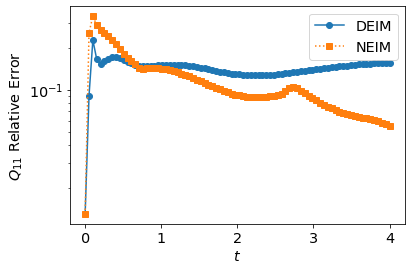

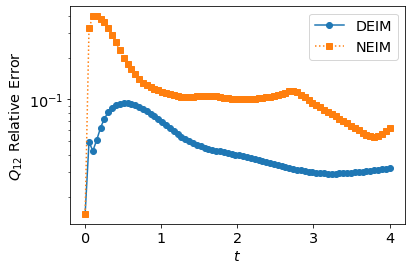

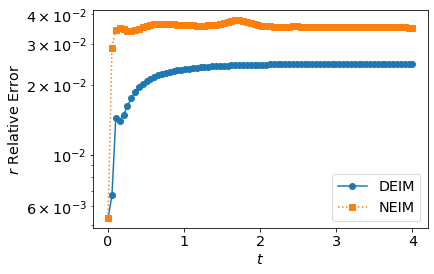

In [21]:
plt.semilogy(tVals, error_time_deim_Q11, marker='o', label="DEIM")
plt.semilogy(tVals, error_time_neim_Q11, marker='s', linestyle='dotted', label="NEIM")
plt.xlabel("$t$")
plt.ylabel("$Q_{11}$ Relative Error")
plt.legend()
plt.savefig(f'./Paper Figures/q11_relative_error_t.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/q11_relative_error_t_x.npy", 'wb') as file_obj:
    np.save(file_obj, tVals)
with open(f"./Paper Data/q11_relative_error_t_neim.npy", 'wb') as file_obj:
    np.save(file_obj, error_time_neim_Q11)
with open(f"./Paper Data/q11_relative_error_t_deim.npy", 'wb') as file_obj:
    np.save(file_obj, error_time_deim_Q11)
plt.show()

plt.semilogy(tVals, error_time_deim_Q12, marker='o', label="DEIM")
plt.semilogy(tVals, error_time_neim_Q12, marker='s', linestyle='dotted', label="NEIM")
plt.xlabel("$t$")
plt.ylabel("$Q_{12}$ Relative Error")
plt.legend()
plt.savefig(f'./Paper Figures/q12_relative_error_t.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/q12_relative_error_t_x.npy", 'wb') as file_obj:
    np.save(file_obj, tVals)
with open(f"./Paper Data/q12_relative_error_t_neim.npy", 'wb') as file_obj:
    np.save(file_obj, error_time_neim_Q12)
with open(f"./Paper Data/q12_relative_error_t_deim.npy", 'wb') as file_obj:
    np.save(file_obj, error_time_deim_Q12)
plt.show()

plt.semilogy(tVals, error_time_deim_r, marker='o', label="DEIM")
plt.semilogy(tVals, error_time_neim_r, marker='s', linestyle='dotted', label="NEIM")
plt.xlabel("$t$")
plt.ylabel("$r$ Relative Error")
plt.legend()
plt.savefig(f'./Paper Figures/r_relative_error_t.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/r_relative_error_t_x.npy", 'wb') as file_obj:
    np.save(file_obj, tVals)
with open(f"./Paper Data/r_relative_error_t_neim.npy", 'wb') as file_obj:
    np.save(file_obj, error_time_neim_r)
with open(f"./Paper Data/r_relative_error_t_deim.npy", 'wb') as file_obj:
    np.save(file_obj, error_time_deim_r)
plt.show()

### Total Relative Error Over $a$

In [ ]:
a_list = np.arange(-0.5, 0.55, 0.05)
error_deim = []
error_neim = []
for a in a_list:
    Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(a, neim_modes)
    error_deim.append(np.linalg.norm(Q1_ - (U_Q1 @ Q1_deim.T).T) / np.linalg.norm(Q1_))
    error_neim.append(np.linalg.norm(Q1_ - (U_Q1 @ Q1_neim.T).T) / np.linalg.norm(Q1_))

In [ ]:
plt.semilogy(a_list, error_deim, marker='o', label="DEIM")
plt.semilogy(a_list, error_neim, marker='s', linestyle='dotted', label="NEIM")
plt.xlabel("$a$")
plt.ylabel("$Q_{11}$ Relative Error")
plt.legend()
plt.savefig(f'./Paper Figures/q11_relative_error_for_a.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/q11_relative_error_for_a_x.npy", 'wb') as file_obj:
    np.save(file_obj, a_list)
with open(f"./Paper Data/q11_relative_error_for_a_neim.npy", 'wb') as file_obj:
    np.save(file_obj, error_neim)
with open(f"./Paper Data/q11_relative_error_for_a_deim.npy", 'wb') as file_obj:
    np.save(file_obj, error_deim)
plt.show()

### DEIM-NEIM Error Contour Plots for $Q_{11}$

In [22]:
a_list = np.arange(-0.5, 0.55, 0.05)
error_deim_contour = []
error_neim_contour = []
for a in a_list:
    error_deim_contour.append([])
    error_neim_contour.append([])
    
    Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(a, neim_modes)
    
    for i, t in enumerate(tVals):
        error_deim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_deim.T).T[i])) #/ np.linalg.norm(Q1_[i]))
        error_neim_contour[-1].append(np.linalg.norm(Q1_[i] - (U_Q1 @ Q1_neim.T).T[i])) #/ np.linalg.norm(Q1_[i]))

a_contour, time_contour = np.meshgrid(tVals, a_list)

Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.59it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 470.87it/s]


Relative Error (DEIM): 0.1533586323491022
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 325.47it/s]


Relative Error (NEIM): 0.17037270830259876
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.63it/s]


Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 977.08it/s]


Relative Error (DEIM): 0.13105537296790654
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 324.95it/s]


Relative Error (NEIM): 0.10683100430268695
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.26it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1293.37it/s]


Relative Error (DEIM): 0.11080888918974664
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 277.34it/s]


Relative Error (NEIM): 0.07919182005257908
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.62it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1577.98it/s]


Relative Error (DEIM): 0.092572232881817
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 354.83it/s]


Relative Error (NEIM): 0.06588369172603559
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.87it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1585.37it/s]


Relative Error (DEIM): 0.07628498474964063
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 193.31it/s]


Relative Error (NEIM): 0.06716972802037562
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.69it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1318.80it/s]


Relative Error (DEIM): 0.061898726327401954
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 161.34it/s]


Relative Error (NEIM): 0.05577611023050222
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.57it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1502.41it/s]


Relative Error (DEIM): 0.049411687632736734
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 315.74it/s]


Relative Error (NEIM): 0.06108613987206094
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.89it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2092.33it/s]


Relative Error (DEIM): 0.03892330602092283
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 391.08it/s]


Relative Error (NEIM): 0.05626138974102191
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.68it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 2047.92it/s]


Relative Error (DEIM): 0.030717066920665462
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 294.77it/s]


Relative Error (NEIM): 0.05208074645645826
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.38it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1643.48it/s]


Relative Error (DEIM): 0.025314842755686608
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 318.36it/s]


Relative Error (NEIM): 0.06725491384842128
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.15it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1286.52it/s]


Relative Error (DEIM): 0.02321984164716445
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 343.72it/s]


Relative Error (NEIM): 0.08777180497520941
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.17it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1837.16it/s]


Relative Error (DEIM): 0.02420220080447438
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 391.06it/s]


Relative Error (NEIM): 0.07983442341496745
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.41it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1114.49it/s]


Relative Error (DEIM): 0.02720106863337176
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 326.51it/s]


Relative Error (NEIM): 0.18610182372276804
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.69it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1325.64it/s]


Relative Error (DEIM): 0.031152381311977898
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 361.34it/s]


Relative Error (NEIM): 0.10387144950953646
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 62.57it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1623.19it/s]


Relative Error (DEIM): 0.03540934208432492
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 299.98it/s]


Relative Error (NEIM): 0.13334415802862232
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.72it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1747.28it/s]


Relative Error (DEIM): 0.03965034336021539
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 329.55it/s]


Relative Error (NEIM): 0.12120528792456457
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.10it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1670.51it/s]


Relative Error (DEIM): 0.043728422216988985
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 348.58it/s]


Relative Error (NEIM): 0.10066990563281468
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.16it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1203.99it/s]


Relative Error (DEIM): 0.047582473912230666
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 263.92it/s]


Relative Error (NEIM): 0.10945528076949108
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.90it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1093.50it/s]


Relative Error (DEIM): 0.05119329252449926
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 310.16it/s]


Relative Error (NEIM): 0.1169839975827968
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.62it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1458.88it/s]


Relative Error (DEIM): 0.054562204946090605
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 266.68it/s]


Relative Error (NEIM): 0.11519834320810816
Computing scheme...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.64it/s]


Computing scheme...


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1579.81it/s]


Relative Error (DEIM): 0.05770044316572506
Computing scheme...


100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 231.69it/s]


Relative Error (NEIM): 0.11471054415375226


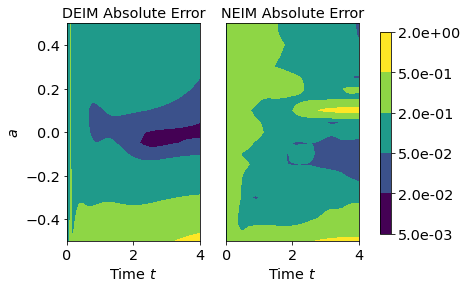

In [23]:
fig, ax = plt.subplots(1, 2)

locator = ticker.LogLocator(base=10, subs=(2, 5))

cs = ax[0].contourf(a_contour, time_contour, error_deim_contour, locator=locator,
                    vmin=min(np.min(error_deim_contour), np.min(error_neim_contour)), 
                    vmax=max(np.max(error_deim_contour), np.max(error_neim_contour)))
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("$a$")
ax[0].set_title("DEIM Absolute Error")#Relative Error")

cs = ax[1].contourf(a_contour, time_contour, error_neim_contour, locator=locator, 
                    vmin=min(np.min(error_deim_contour), np.min(error_neim_contour)), 
                    vmax=max(np.max(error_deim_contour), np.max(error_neim_contour)))
ax[1].set_xlabel("Time $t$")
ax[1].set_title("NEIM Absolute Error")#Relative Error")
ax[1].set_xlabel("Time $t$")
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_yticks([])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])

cbformat = ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))

fig.colorbar(cs, cax=cbar_ax, ticks=locator, format='%.1e')

"""
plt.savefig(f'./Paper Figures/q11_deim_neim_relative_error_contour.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/q11_deim_neim_relative_error_contour_a.npy", 'wb') as file_obj:
    np.save(file_obj, a_contour)
with open(f"./Paper Data/q11_deim_neim_relative_error_contour_t.npy", 'wb') as file_obj:
    np.save(file_obj, time_contour)
with open(f"./Paper Data/q11_deim_neim_relative_error_contour_deim.npy", 'wb') as file_obj:
    np.save(file_obj, error_deim_contour)
with open(f"./Paper Data/q11_deim_neim_relative_error_contour_neim.npy", 'wb') as file_obj:
    np.save(file_obj, error_neim_contour)
"""
plt.savefig(f'./Paper Figures/q11_deim_neim_absolute_error_contour.pdf', bbox_inches='tight', dpi=500)
with open(f"./Paper Data/q11_deim_neim_absolute_error_contour_a.npy", 'wb') as file_obj:
    np.save(file_obj, a_contour)
with open(f"./Paper Data/q11_deim_neim_absolute_error_contour_t.npy", 'wb') as file_obj:
    np.save(file_obj, time_contour)
with open(f"./Paper Data/q11_deim_neim_absolute_error_contour_deim.npy", 'wb') as file_obj:
    np.save(file_obj, error_deim_contour)
with open(f"./Paper Data/q11_deim_neim_absolute_error_contour_neim.npy", 'wb') as file_obj:
    np.save(file_obj, error_neim_contour)
plt.show()

# Plot solution behavior

In [ ]:
a = -0.25#-0.5
print("a =", a, "NEIM modes =", neim_modes)
Q1_, Q2_, r_, Q1_deim, Q2_deim, r_deim, Q1_neim, Q2_neim, r_neim = solve_deim_neim(a, neim_modes)
Q1_deim, Q2_deim, r_deim = (U_Q1 @ Q1_deim.T).T, (U_Q2 @ Q2_deim.T).T, (U_r @ r_deim.T).T
Q1_neim, Q2_neim, r_neim = (U_Q1 @ Q1_neim.T).T, (U_Q2 @ Q2_neim.T).T, (U_r @ r_neim.T).T

In [ ]:
visualize(interior_point_coords, Q1_, Q2_, r_, num_interior_points, Nt, every=15)

In [ ]:
visualize(interior_point_coords, Q1_deim, Q2_deim, r_deim, num_interior_points, Nt, every=15)

In [ ]:
visualize(interior_point_coords, Q1_neim, Q2_neim, r_neim, num_interior_points, Nt, every=15)

In [ ]:
def visualize2(points, Q1, Q2, r, Q1d, Q2d, rd, Q1n, Q2n, rn, num_interior_points, Nt, every=10, filename="solution"):
    director1x = np.zeros((Nt, points.shape[0]))
    director1y = np.zeros((Nt, points.shape[0]))
    director2x = np.zeros((Nt, points.shape[0]))
    director2y = np.zeros((Nt, points.shape[0]))
    
    director1xd = np.zeros((Nt, points.shape[0]))
    director1yd = np.zeros((Nt, points.shape[0]))
    director2xd = np.zeros((Nt, points.shape[0]))
    director2yd = np.zeros((Nt, points.shape[0]))
    
    director1xn = np.zeros((Nt, points.shape[0]))
    director1yn = np.zeros((Nt, points.shape[0]))
    director2xn = np.zeros((Nt, points.shape[0]))
    director2yn = np.zeros((Nt, points.shape[0]))
    
    Z = np.zeros((Nt, points.shape[0]))
    Zd = np.zeros((Nt, points.shape[0]))
    Zn = np.zeros((Nt, points.shape[0]))
    
    Q = np.zeros((Nt, num_interior_points, 2, 2))
    Qd = np.zeros((Nt, num_interior_points, 2, 2))
    Qn = np.zeros((Nt, num_interior_points, 2, 2))

    for t in tqdm(range(Nt)):
        for i in range(points.shape[0]):
            
            Q[t, i, 0, 0] = Q1[t, i]
            Q[t, i, 0, 1] = Q2[t, i]
            Q[t, i, 1, 0] = Q2[t, i]
            Q[t, i, 1, 1] = -Q1[t, i]
            
            Qd[t, i, 0, 0] = Q1d[t, i]
            Qd[t, i, 0, 1] = Q2d[t, i]
            Qd[t, i, 1, 0] = Q2d[t, i]
            Qd[t, i, 1, 1] = -Q1d[t, i]
            
            Qn[t, i, 0, 0] = Q1n[t, i]
            Qn[t, i, 0, 1] = Q2n[t, i]
            Qn[t, i, 1, 0] = Q2n[t, i]
            Qn[t, i, 1, 1] = -Q1n[t, i]

            eigenvalues, eigenvectors = np.linalg.eigh(Q[t, i]) # 2nd eigenvalue is positive
            eigenvaluesd, eigenvectorsd = np.linalg.eigh(Qd[t, i])
            eigenvaluesn, eigenvectorsn = np.linalg.eigh(Qn[t, i])

            v1 = eigenvectors[:, 0]
            v2 = eigenvectors[:, 1]
            director1x[t, i] = v1[0]
            director1y[t, i] = v1[1]
            director2x[t, i] = v2[0]
            director2y[t, i] = v2[1]
            
            v1d = eigenvectorsd[:, 0]
            v2d = eigenvectorsd[:, 1]
            director1xd[t, i] = v1d[0]
            director1yd[t, i] = v1d[1]
            director2xd[t, i] = v2d[0]
            director2yd[t, i] = v2d[1]
            
            v1n = eigenvectorsn[:, 0]
            v2n = eigenvectorsn[:, 1]
            director1xn[t, i] = v1n[0]
            director1yn[t, i] = v1n[1]
            director2xn[t, i] = v2n[0]
            director2yn[t, i] = v2n[1]
            
            Z[t, i] = np.abs(director2x[t, i] * eigenvalues[1])
            Zd[t, i] = np.abs(director2xd[t, i] * eigenvaluesd[1])
            Zn[t, i] = np.abs(director2xn[t, i] * eigenvaluesn[1])
        
        if t % every == 0:
            num_points_1d = int(np.sqrt(num_interior_points)+0.5)
            plt.clf()
            fig, ax = plt.subplots(1, 3)
            
            cs = ax[0].contourf(np.unique(points[:, 0]),
                         np.unique(points[:, 1]),
                         Z[t, np.lexsort((points[:, 1], points[:, 0]))].reshape(num_points_1d, num_points_1d),
                         vmin=0, vmax=1.1, cmap="Oranges")
            ax[1].contourf(np.unique(points[:, 0]),
                         np.unique(points[:, 1]),
                         Zd[t, np.lexsort((points[:, 1], points[:, 0]))].reshape(num_points_1d, num_points_1d),
                         vmin=0, vmax=1.1, cmap="Oranges")
            ax[2].contourf(np.unique(points[:, 0]),
                         np.unique(points[:, 1]),
                         Zn[t, np.lexsort((points[:, 1], points[:, 0]))].reshape(num_points_1d, num_points_1d),
                         vmin=0, vmax=1.1, cmap="Oranges")
            
            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
            fig.colorbar(cs, cax=cbar_ax)

            #plt.clim(0, 1.1)
            ax[0].quiver(points[:, 0], points[:, 1], director2x[t], director2y[t], scale=30, headaxislength=0, headwidth=0, headlength=0, color='b', pivot='mid')
            ax[1].quiver(points[:, 0], points[:, 1], director2xd[t], director2yd[t], scale=30, headaxislength=0, headwidth=0, headlength=0, color='b', pivot='mid')
            ax[2].quiver(points[:, 0], points[:, 1], director2xn[t], director2yn[t], scale=30, headaxislength=0, headwidth=0, headlength=0, color='b', pivot='mid')
            
            #ax[0].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].set_ylim(ax[0].get_ylim())
            ax[1].set_yticks([])
            ax[2].set_xlim(ax[0].get_xlim())
            ax[2].set_ylim(ax[0].get_ylim())
            ax[2].set_yticks([])
            
            #fig.set_figheight(15)
            fig.set_figwidth(15)

            
            plt.savefig(f'./Paper Figures/{filename}_{t}.pdf', bbox_inches='tight', dpi=500)
            plt.show()
            print(np.max(Z))
    
    plt.show()

In [ ]:
visualize2(interior_point_coords, 
           Q1_, Q2_, r_, 
           Q1_deim, Q2_deim, r_deim, 
           Q1_neim, Q2_neim, r_neim, 
           num_interior_points, Nt, every=1, filename="solution")